# Setting up Mlflow

In [ ]:
# Install the following librairies (it is better to create a venv (or conda) virtual environment first and install these librairies in it)
!pip install mlflow
!pip install --upgrade jinja2
!pip install --upgrade Flask
!pip install setuptools

In [ ]:

# starts an MLflow server locally.
!mlflow server --host 127.0.0.1 --port 8080


## Using the MLflow Client API


- Initiate a new Experiment.

- Start Runs within an Experiment.

- Document parameters, metrics, and tags for your Runs.

- Log artifacts linked to runs, such as models, tables, plots, and more.



In [1]:
from mlflow import MlflowClient
from pprint import pprint
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import LogisticRegression


In [2]:
# In order to connect to the tracking server, we’ll need to use the uri that we assigned the server when we started it.

client = MlflowClient(tracking_uri="http://127.0.0.1:8080")

#it allows programmatic interaction with the MLflow tracking server.

We now have a client interface to the tracking server that can both send data to and retrieve data from the tracking server.



In [3]:
all_experiments = client.search_experiments()

print(all_experiments)


[<Experiment: artifact_location='mlflow-artifacts:/0', creation_time=1725480014100, experiment_id='0', last_update_time=1725480014100, lifecycle_stage='active', name='Default', tags={}>]


### create an experiment

In [4]:
# Provide an Experiment description that will appear in the UI
experiment_description = (
    "that estimates the probability of default. "
    "This experiment contains the produce models for default credit."
)

# Provide searchable tags that define characteristics of the Runs that
# will be in this Experiment
experiment_tags = {
    "project_name": "credit_default-forecasting",
    "store_dept": "produce",
    "team": "stores-ml",
    "project_quarter": "Q3-2023",
    "mlflow.note.content": experiment_description,
}

# Create the Experiment, providing a unique name
produce_apples_experiment = client.create_experiment(
    name="Credit_Models", tags=experiment_tags
)


In [5]:
# Use search_experiments() to search on the project_name tag key

apples_experiment = client.search_experiments(
    filter_string="tags.`project_name` = 'credit_default-forecasting'"
)

print(vars(apples_experiment[0]))


{'_experiment_id': '782787135880584632', '_name': 'Credit_Models', '_artifact_location': 'mlflow-artifacts:/782787135880584632', '_lifecycle_stage': 'active', '_tags': {'mlflow.note.content': 'that estimates the probability of default. This experiment contains the produce models for default credit.', 'project_name': 'credit_default-forecasting', 'project_quarter': 'Q3-2023', 'store_dept': 'produce', 'team': 'stores-ml'}, '_creation_time': 1725481977500, '_last_update_time': 1725481977500}


### Create a dataset about apples

In [7]:
import pandas as pd
import numpy as np
#from datetime import datetime, timedelta

import seaborn as sns
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings('ignore')

Matplotlib is building the font cache; this may take a moment.


In [8]:
data = pd.read_csv("Loan_Data.csv")
data.head()

,customer_id,credit_lines_outstanding,loan_amt_outstanding,total_debt_outstanding,income,years_employed,fico_score,default
0,8153374,0,5221.545193,3915.471226,78039.38546,5,605,0
1,7442532,5,1958.928726,8228.752520,26648.43525,2,572,1
2,2256073,0,3363.009259,2027.830850,65866.71246,4,602,0
3,4885975,0,4766.648001,2501.730397,74356.88347,5,612,0
4,4700614,1,1345.827718,1768.826187,23448.32631,6,631,0


In [9]:
# Supprimer la colonne 'customer_id'
data = data.drop(columns=['customer_id'])

### Logging our first runs with MLflow

In [20]:
import mlflow
#from sklearn.model_selection import train_test_split
#from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

from sklearn.model_selection import train_test_split
import statsmodels.api as sm




In [21]:
# This function call sets the global tracking URI for the current session.
# It’s a convenient way to configure the tracking server URI without creating a separate client instance.

mlflow.set_tracking_uri("http://127.0.0.1:8080")


In [23]:
# Sets the current active experiment to the "Credit_Models" experiment and
# returns the Experiment metadata
apple_experiment = mlflow.set_experiment("Credit_Models")

# Define a run name for this iteration of training.
# If this is not set, a unique name will be auto-generated for your run.
run_name = "credit_reglogistique_test"

# Define an artifact path that the model will be saved to.
artifact_path = "reg_logistique_credit"


In [24]:
# Split the data into features and target and drop irrelevant date field and target field
X = data.drop('default', axis=1)  # Variables prédictives
y = data['default']  # Variable cible

# Ajouter une constante pour l'interception
X = sm.add_constant(X)
# Diviser la base de données en train et test
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

                           Logit Regression Results                           
Dep. Variable:                default   No. Observations:                 8000
Model:                          Logit   Df Residuals:                     7993
Method:                           MLE   Df Model:                            6
Date:                Thu, 05 Sep 2024   Pseudo R-squ.:                  0.9983
Time:                        22:32:09   Log-Likelihood:                -6.4342
converged:                       True   LL-Null:                       -3865.0
Covariance Type:            nonrobust   LLR p-value:                     0.000
                               coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------------------
const                      133.9888     56.035      2.391      0.017      24.162     243.816
credit_lines_outstanding   211.3941     88.462      2.390      0.017      38.011     384.

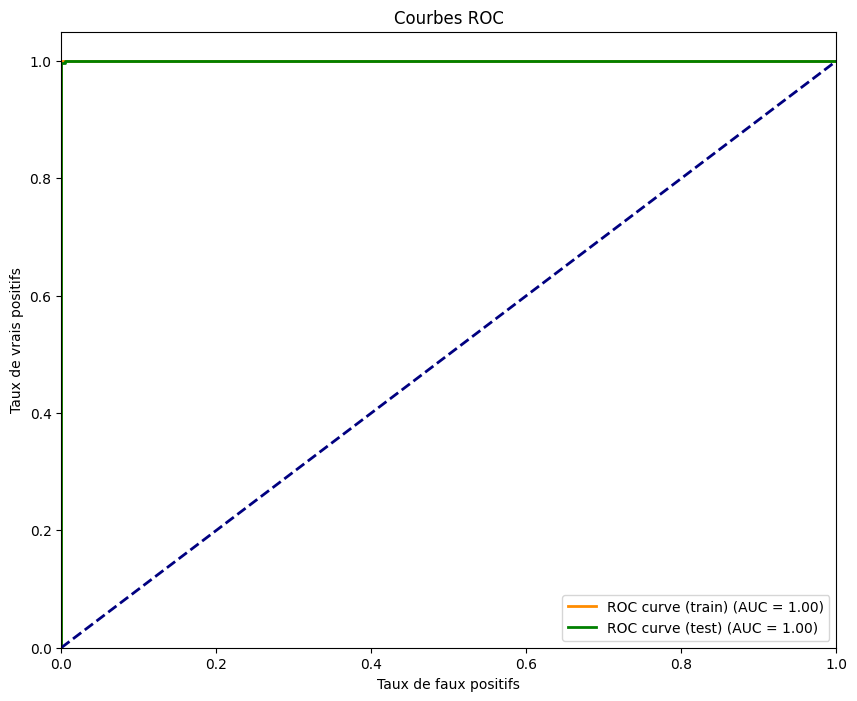

2024/09/05 22:33:03 INFO mlflow.tracking._tracking_service.client: 🏃 View run credit_reglogistique_test at: http://127.0.0.1:8080/#/experiments/782787135880584632/runs/5c7412837aa348149de4cb2f792f44b2.
2024/09/05 22:33:03 INFO mlflow.tracking._tracking_service.client: 🧪 View experiment at: http://127.0.0.1:8080/#/experiments/782787135880584632.


In [28]:
# Spécification des paramètres dans une cellule séparée
parametres = {
    'method': 'newton',  # Méthode d'optimisation
    'maxiter': 100,      # Nombre maximum d'itérations
    'disp': False        # Affichage des informations d'optimisation
}



# Création et entraînement du modèle de régression logistique
modele = sm.Logit(y_train, X_train)

result = modele.fit(**parametres)


# Afficher le résumé des résultats de la régression
print(result.summary())



from sklearn.metrics import roc_curve, auc
# Obtenir les prédictions du modèle sur l'ensemble d'entraînement et de test
y_train_pred = result.predict(X_train)
y_test_pred = result.predict(X_test)

# Calculer les courbes ROC et les aires sous la courbe (AUC)
fpr_train, tpr_train, thresholds_train = roc_curve(y_train, y_train_pred)
roc_auc_train = auc(fpr_train, tpr_train)

fpr_test, tpr_test, thresholds_test = roc_curve(y_test, y_test_pred)
roc_auc_test = auc(fpr_test, tpr_test)

# Tracer les courbes ROC
plt.figure(figsize=(10, 8))
plt.plot(fpr_train, tpr_train, color='darkorange', lw=2, label='ROC curve (train) (AUC = %0.2f)' % roc_auc_train)
plt.plot(fpr_test, tpr_test, color='green', lw=2, label='ROC curve (test) (AUC = %0.2f)' % roc_auc_test)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('Taux de faux positifs')
plt.ylabel('Taux de vrais positifs')
plt.title('Courbes ROC')
plt.legend(loc="lower right")
plt.show()



# Calculate error metrics
mae = mean_absolute_error(y_test, y_test_pred)
mse = mean_squared_error(y_test, y_test_pred)
rmse = np.sqrt(mse)
r2 = r2_score(y_test, y_test_pred)


#from sklearn.metrics import classification_report

from sklearn.metrics import confusion_matrix

# Prédire les classes sur la base de test
y_pred = result.predict(X_test) > 0.5

# Calculer la matrice de confusion
cm = confusion_matrix(y_test, y_pred)
TN, FP, FN, TP = cm.ravel()

# Calculer le recall
recall = TP / (TP + FN)
#print(f'Recall: {recall}')

# Calculer l'accuracy
accuracy = (TP + TN) / (TP + TN + FP + FN)
#print(f'Accuracy: {accuracy}')









# Assemble the metrics we're going to write into a collection
metrics = {"mae": mae, "mse": mse, "rmse": rmse, "r2": r2, "recall": recall, "accuracy": accuracy}

# Initiate the MLflow run context
with mlflow.start_run(run_name=run_name) as run:
    # Log the parameters used for the model fit
    mlflow.log_params(parametres)


    # Log the error metrics that were calculated during validation
    mlflow.log_metrics(metrics)

    # Log an instance of the trained model for later use
    mlflow.sklearn.log_model(
        sk_model=result, input_example=X_test, artifact_path=artifact_path
        )

In [26]:

from sklearn.metrics import classification_report

# Prédire les classes sur la base de test
y_pred = result.predict(X_test) > 0.5

# Générer le rapport de classification
report = classification_report(y_test, y_pred)

# Afficher le rapport de classification
print(report)

              precision    recall  f1-score   support

           0       1.00      1.00      1.00      1652
           1       1.00      0.99      0.99       348

    accuracy                           1.00      2000
   macro avg       1.00      0.99      1.00      2000
weighted avg       1.00      1.00      1.00      2000

